# AlphaBind Manuscript Analysis

The following notebook reproduces analyses and plots generated for the AlphaBind manuscript.

This notebook reads in data from `../data` and deposits resulting plots in `../plots`. To run this notebook, use the provided conda environment specified in `alphabind_analysis.yml`.

### Imports, setup

---

In [1]:
import re
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import entropy, false_discovery_control, mannwhitneyu

warnings.filterwarnings("ignore")

In [2]:
# set paths
DATA_DIR = Path("../data/")
ALPHASEQ_VALIDATION_DIR = DATA_DIR / "alphaseq" / "validation"
ALPHASEQ_FINETUNING_DIR = DATA_DIR / "alphaseq" / "fine-tuning"
ANARCI_DIR = DATA_DIR / "anarci"
BLI_DIR = DATA_DIR / "bli"
PLOT_DIR = Path("../plots")

# plotting variables
PEMBRO_COLOR = "#8A3FFC"  # purple
VHH72_COLOR = "#FA4D56"  # red
PP489_COLOR = "#33B1FF"  # blue
TRASTCDR_COLOR = "#6fdc8c"  # light green
TRASTFULL_COLOR = "#198038"  # dark green

In [3]:
# read in alphaseq validation data
df_vhh72 = pl.read_csv(ALPHASEQ_VALIDATION_DIR / "vhh72_validation_alphaseq.csv")
df_pembro = pl.read_csv(
    ALPHASEQ_VALIDATION_DIR / "pembrolizumab-scfv_validation_alphaseq.csv"
)
df_pp489 = pl.read_csv(ALPHASEQ_VALIDATION_DIR / "aab-pp489_validation_alphaseq.csv")

df_trast_cdr = pl.read_csv(
    ALPHASEQ_VALIDATION_DIR / "trastuzumab-scfv-cdr_validation_alphaseq.csv"
)
df_trast_full = pl.read_csv(
    ALPHASEQ_VALIDATION_DIR / "trastuzumab-scfv-full_validation_alphaseq.csv"
)

### Successful binder metrics

---

In [4]:
# Define a successful binder as one with an on-target affinity of <1 uM, and a specific binder as a successful binder with 100x greater on-target than off-target affinity


def successful_binders(df):
    df_alphabind = df.filter(pl.col("model") == "alphabind")
    df_binders = df_alphabind.filter(pl.col("alphaseq_affinity") < 3)
    df_specific = df_binders.filter(
        pl.col("alphaseq_affinity") - pl.col("avg_off_target_affinity") < -2
    )
    n_total, n_binders, n_specific = (
        df_alphabind.shape[0],
        df_binders.shape[0],
        df_specific.shape[0],
    )
    print(
        f"Successful binders out of total:\t{n_binders} / {n_total} ({round(n_binders * 100 / n_total, 3)})"
    )
    print(
        f"Specific binders out of successful binders:\t{n_specific} / {n_binders} ({round(n_specific * 100 / n_binders, 3)})"
    )
    print("------------\n")


print("VHH72")
successful_binders(df_vhh72)

print("Pembro")
successful_binders(df_pembro)
print("PP489")
successful_binders(df_pp489)

print("TrastCDR")
successful_binders(df_trast_cdr)
print("TrastFull")
successful_binders(df_trast_full)

VHH72
Successful binders out of total:	6924 / 7433 (93.152)
Specific binders out of successful binders:	5532 / 6924 (79.896)
------------

Pembro
Successful binders out of total:	6308 / 7488 (84.241)
Specific binders out of successful binders:	5830 / 6308 (92.422)
------------

PP489
Successful binders out of total:	7312 / 7456 (98.069)
Specific binders out of successful binders:	7107 / 7312 (97.196)
------------

TrastCDR
Successful binders out of total:	2195 / 3631 (60.452)
Specific binders out of successful binders:	1722 / 2195 (78.451)
------------

TrastFull
Successful binders out of total:	1716 / 7490 (22.911)
Specific binders out of successful binders:	1716 / 1716 (100.0)
------------



### Ablation analysis

---

Compare the medians of the samples generated by different models. Perform U tests with BH correction to check if differences in samples is statistically significant.

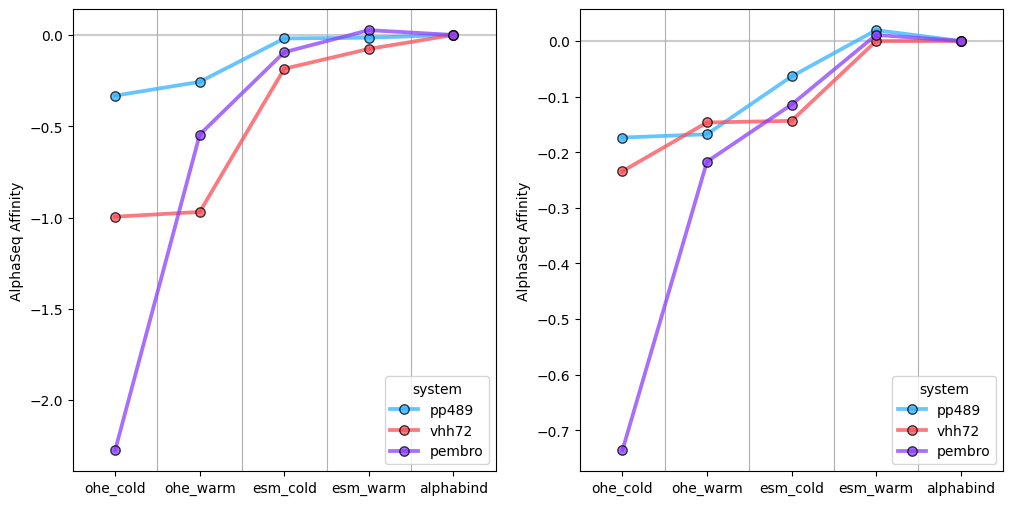

In [5]:
def plot_model_ablation_medians(top_p=0.1, ax=None):
    """
    Creates a point plot comparing model ablation results across different systems using median AlphaSeq affinity scores.

    The function processes data from three different systems (pembro, vhh72, and pp489), calculating median affinity
    scores for the top performing predictions based on the specified percentile. Results are plotted relative to the
    AlphaBind baseline for each system.

    Parameters
    ----------
    top_p : float, optional (default=0.1)
        The top percentile of predictions to consider when calculating median affinities.
        For example, 0.1 means use the top 10% of predictions ranked by alphaseq_affinity.

    ax : matplotlib.axes.Axes, optional (default=None)
        The axes on which to draw the plot. If None, creates a new figure with axes.
    """

    dfs = []
    for df, system in zip(
        [df_pembro, df_vhh72, df_pp489], ["pembro", "vhh72", "pp489"]
    ):
        df = (
            df.with_columns(pl.col("alphaseq_affinity").fill_null(6))
            .group_by("model")
            .map_groups(
                lambda group: group.sort(
                    "alphaseq_affinity", descending=False, nulls_last=True
                ).head(int(group.height * top_p))
            )
            .group_by("model")
            .agg(pl.col("alphaseq_affinity").median())
            .with_columns(pl.lit(system).alias("system"))
        )
        baseline = df.filter(pl.col("model") == "alphabind")[0, 1]
        df = df.with_columns(-(pl.col("alphaseq_affinity") - baseline))
        dfs.append(df)
    df_all = pl.concat(dfs)

    system_order = ["pp489", "vhh72", "pembro"]
    model_order = ["ohe_cold", "ohe_warm", "esm_cold", "esm_warm", "alphabind"]

    if not ax:
        fig, ax = plt.subplots(1, figsize=(6, 8))

    sns.pointplot(
        data=df_all,
        x="model",
        y="alphaseq_affinity",
        hue="system",
        order=model_order,
        hue_order=system_order,
        estimator="median",
        palette=[PP489_COLOR, VHH72_COLOR, PEMBRO_COLOR],
        errorbar=None,
        markeredgecolor="k",
        markeredgewidth=1,
        alpha=0.75,
        ax=ax,
    )

    ax.axhline(0, c="#ccc", zorder=-1)
    ax.set_xticks(np.arange(0.5, 4, 1), minor=True)
    ax.tick_params(which="minor", axis="x", length=0)
    ax.grid(which="minor")

    ax.set_ylabel("AlphaSeq Affinity")
    ax.set_xlabel("")


fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_model_ablation_medians(1, ax=axs[0])
plot_model_ablation_medians(0.1, ax=axs[1])

fig.savefig(
    PLOT_DIR / "model_ablation_medians", dpi=300, facecolor="white", bbox_inches="tight"
)

In [6]:
def ablation_utest(top_p=1):
    """
    Performs Mann-Whitney U tests comparing each model's performance against the AlphaBind baseline.

    For each system (pembro, vhh72, and pp489), this function compares the AlphaSeq affinity scores
    of different models against the AlphaBind baseline using one-sided Mann-Whitney U tests. The tests
    check if models perform significantly worse than AlphaBind (alternative hypothesis: model scores are
    greater than baseline, where greater values indicate worse performance).

    Parameters
    ----------
    top_p : float, optional (default=1)
        The proportion of candidates to consider in the analysis, sorted by AlphaSeq affinity.
        For example, top_p=0.5 would analyze only the top 50% of predictions.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing test results with columns:
        - model: str, name of the model tested
        - u_stat: float, Mann-Whitney U statistic
        - pval: float, raw p-value from the U test
        - system: str, system identifier (pembro, vhh72, or pp489)
        - adj-pval: float, p-values adjusted for multiple comparisons using FDR control
    """
    res = []
    for df, system in zip(
        [df_pembro, df_vhh72, df_pp489], ["pembro", "vhh72", "pp489"]
    ):
        df = (
            df.filter(pl.col("model").is_not_null())
            .with_columns(pl.col("alphaseq_affinity").fill_null(6))
            .group_by("model")
            .map_groups(
                lambda group: group.sort(
                    "alphaseq_affinity", descending=False, nulls_last=True
                ).head(int(group.height * top_p))
            )
        )
        baseline = df.filter(pl.col("model") == "alphabind")[
            "alphaseq_affinity"
        ].fill_null(6)
        stats = []
        for model in df.filter(pl.col("model") != "alphabind")["model"].unique():
            df_sub = df.filter(pl.col("model") == model)["alphaseq_affinity"].fill_null(
                6
            )
            u_test = mannwhitneyu(df_sub, baseline, alternative="greater")
            stats.append([model, u_test[0], u_test[1]])
        df_stats = pl.DataFrame(stats, schema=["model", "u_stat", "pval"]).with_columns(
            pl.lit(system).alias("system")
        )
        res.append(df_stats)
    df_res = pl.concat(res)
    df_res = df_res.with_columns(
        pl.Series(false_discovery_control(df_res["pval"])).alias("adj-pval")
    )
    return df_res.sort(["model", "system"])


df_stats_all = ablation_utest()
df_stats_top10p = ablation_utest(top_p=0.1)

In [7]:
df_stats_all

model,u_stat,pval,system,adj-pval
str,f64,f64,str,f64
"""esm_cold""",3.0652e7,2.5861e-23,"""pembro""",3.4481e-23
"""esm_cold""",2.8468572e7,0.014464,"""pp489""",0.015779
"""esm_cold""",3.3023e7,9.3053e-88,"""vhh72""",1.5952e-87
"""esm_warm""",2.7836307e7,0.765224,"""pembro""",0.765224
"""esm_warm""",2.8191e7,0.012567,"""pp489""",0.01508
…,…,…,…,…
"""ohe_cold""",4.0098e7,0.0,"""pp489""",0.0
"""ohe_cold""",4.2544e7,0.0,"""vhh72""",0.0
"""ohe_warm""",3.8277e7,0.0,"""pembro""",0.0


In [8]:
df_stats_top10p

model,u_stat,pval,system,adj-pval
str,f64,f64,str,f64
"""esm_cold""",417901.5,1.0129e-61,"""pembro""",1.5194e-61
"""esm_cold""",400352.0,1.1522e-48,"""pp489""",1.5362e-48
"""esm_cold""",472562.5,1.3443e-121,"""vhh72""",2.6886e-121
"""esm_warm""",258937.0,0.99364,"""pembro""",1.0
"""esm_warm""",228348.0,1.0,"""pp489""",1.0
…,…,…,…,…
"""ohe_cold""",494920.5,9.2216e-150,"""pp489""",2.7665e-149
"""ohe_cold""",506813.5,3.1699e-175,"""vhh72""",1.9019e-174
"""ohe_warm""",479458.0,7.2088e-126,"""pembro""",1.7301e-125


### Performance across edit distances analysis

---

Compare AlphaBind candidate affinities to those in the fine-tuning datasets, across edit distances. Uses fold improvement over average measured parental affinity as metric.

In [9]:
# read in fine-tuning data
df_pembro_ft = pl.read_csv(
    ALPHASEQ_FINETUNING_DIR / "pembrolizumab-scfv_fine-tuning_alphaseq.csv"
)
df_pp489_ft = pl.read_csv(
    ALPHASEQ_FINETUNING_DIR / "aab-pp489_fine-tuning_alphaseq.csv"
)
df_vhh72_ft = pl.read_csv(ALPHASEQ_FINETUNING_DIR / "vhh72_fine-tuning_alphaseq.csv")

In [10]:
def plot_violins_ft_val(df_ft, df_val, ax=None, title="", color="k"):
    """
    Creates a split violin plot comparing affinity margins across edit distances for two datasets.

    Generates a violin plot showing the distribution of parental affinity fold changes at different
    edit distances from wild type, split between fine-tuning (ft) and validation (val) data. The plot
    includes reference lines at key fold-change thresholds.

    Parameters
    ----------
    df_ft : polars.DataFrame
        Fine-tuning dataset containing 'edit_distance' and 'parental_aff_margin' columns
    df_val : polars.DataFrame
        Validation dataset containing 'edit_distance', 'parental_aff_margin', and 'model' columns
    ax : matplotlib.axes.Axes, optional
        Axes on which to draw the plot. Creates new figure if None.
    title : str, optional
        Title for the plot
    color : str, optional
        Color for the fine-tuning violin plots (default: 'k')
    """
    df_ft = df_ft.with_columns(pl.lit("ft").alias("source"))
    df_ft = df_ft.filter(pl.col("edit_distance") > 0)
    df_val = df_val.with_columns(pl.lit("val").alias("source")).filter(
        pl.col("model") == "alphabind"
    )
    df_all = pl.concat(
        [
            df_ft[["source", "parental_aff_margin", "edit_distance"]],
            df_val[["source", "parental_aff_margin", "edit_distance"]],
        ]
    ).to_pandas()

    if not ax:
        fig, ax = plt.subplots(1, figsize=(12, 4))

    sns.violinplot(
        data=df_all,
        x="edit_distance",
        y="parental_aff_margin",
        hue="source",
        split=True,
        inner=None,
        ax=ax,
        bw_adjust=0.5,
        linecolor="k",
        linewidth=0.6,
        cut=0,
        palette=["#ccc", color],
        saturation=0.75,
        gap=0.1,
    )

    ax.axhline(0, zorder=-1, color="#888", alpha=0.75, linewidth=1)
    ax.axhline(-1, zorder=-1, color="#999", alpha=0.75, dashes=[4], linewidth=1)
    ax.axhline(-2, zorder=-1, color="#999", alpha=0.75, dashes=[4], linewidth=1)

    ax.set_title(title, fontweight="bold")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.despine()

    ax.set_ylabel("Parental Affinity Fold Change")
    ax.set_xlabel("Edit Distance from Parental")
    ax.set_xticks(np.arange(0, 11), labels=np.arange(1, 12))
    ax.set_ylim(-3, 4)
    ax.set_yticks(
        np.arange(-3, 4.1),
        labels=[
            "1,000x",
            "100x",
            "10x",
            "1x",
            "1/10x",
            "1/100x",
            "1/1,000x",
            "1/10,000x",
        ],
    )

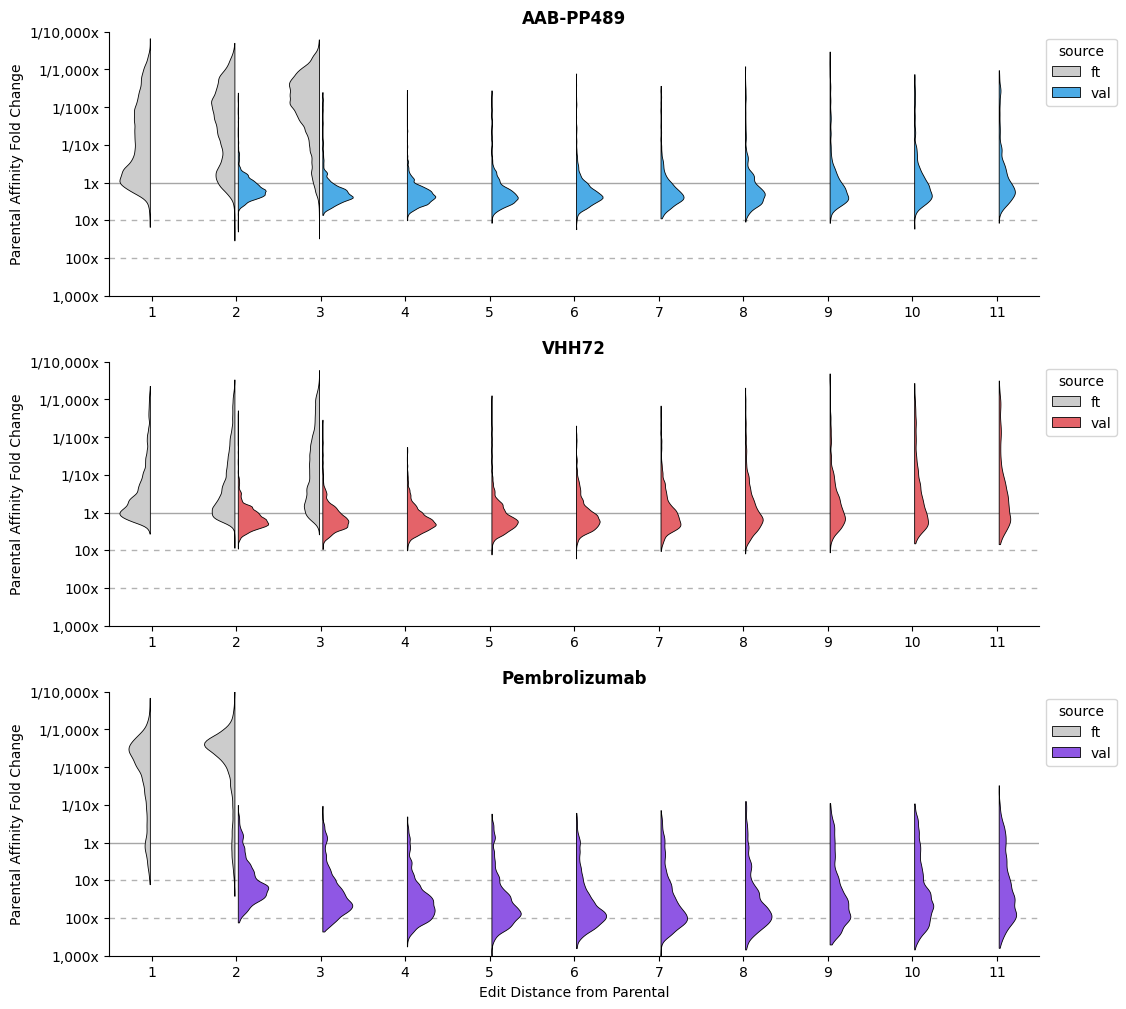

In [11]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 12), gridspec_kw={"hspace": 0.25})
plot_violins_ft_val(df_pp489_ft, df_pp489, axs[0], title="AAB-PP489", color=PP489_COLOR)
plot_violins_ft_val(df_vhh72_ft, df_vhh72, axs[1], title="VHH72", color=VHH72_COLOR)
plot_violins_ft_val(
    df_pembro_ft, df_pembro, axs[2], title="Pembrolizumab", color=PEMBRO_COLOR
)

axs[0].set_xlabel("")
axs[1].set_xlabel("")

fig.savefig(
    PLOT_DIR / "alphabind_violins_by_distance",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

In [12]:
def plot_violins_val(df_val, ax=None, title="", color="k"):
    """
    Creates a violin plot showing affinity margins across edit distances for validation data only.

    Similar to plot_violins_iter0_iter1(), but generates a violin plot for just the validation dataset,
    showing the distribution of parental affinity fold changes at different edit distances from wild type.
    Includes reference lines at key fold-change thresholds.

    Parameters
    ----------
    df_val : polars.DataFrame
        Validation dataset containing 'edit_distance', 'parental_aff_margin', and 'model' columns
    ax : matplotlib.axes.Axes, optional
        Axes on which to draw the plot. Creates new figure if None.
    title : str, optional
        Title for the plot
    color : str, optional
        Color for the violin plots (default: 'k')
    """
    df_val = df_val.with_columns(pl.lit("val").alias("source"))
    df_val = df_val.filter(pl.col("model") == "alphabind")
    df_all = pl.concat(
        [df_val[["source", "parental_aff_margin", "edit_distance"]]]
    ).to_pandas()

    if not ax:
        fig, ax = plt.subplots(1, figsize=(12, 4))

    sns.violinplot(
        data=df_all,
        x="edit_distance",
        y="parental_aff_margin",
        hue="source",
        split=True,
        inner=None,
        ax=ax,
        hue_order=["ft", "val"],
        bw_adjust=0.5,
        linecolor="k",
        linewidth=0.6,
        cut=0,
        palette=["#ccc", color],
        saturation=0.75,
        native_scale=True,
        gap=0.5,
        dodge=False,
    )

    ax.axhline(0, zorder=-1, color="#888", alpha=0.75, linewidth=1)
    ax.axhline(-1, zorder=-1, color="#999", alpha=0.75, dashes=[4], linewidth=1)
    ax.axhline(-2, zorder=-1, color="#999", alpha=0.75, dashes=[4], linewidth=1)
    ax.set_title(title, fontweight="bold")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.despine()

    ax.set_ylabel("Parental Affinity Fold Change")
    ax.set_xlabel("Edit Distance from Parental")
    ax.set_xticks(np.arange(0.5, 11), labels=np.arange(1, 12))
    ax.set_xlim(0, 11.5)
    ax.set_ylim(-3, 5)
    ax.set_yticks(
        np.arange(-3, 5.1),
        labels=[
            "1,000x",
            "100x",
            "10x",
            "1x",
            "1/10x",
            "1/100x",
            "1/1,000x",
            "1/10,000x",
            "1/100,000x",
        ],
    )

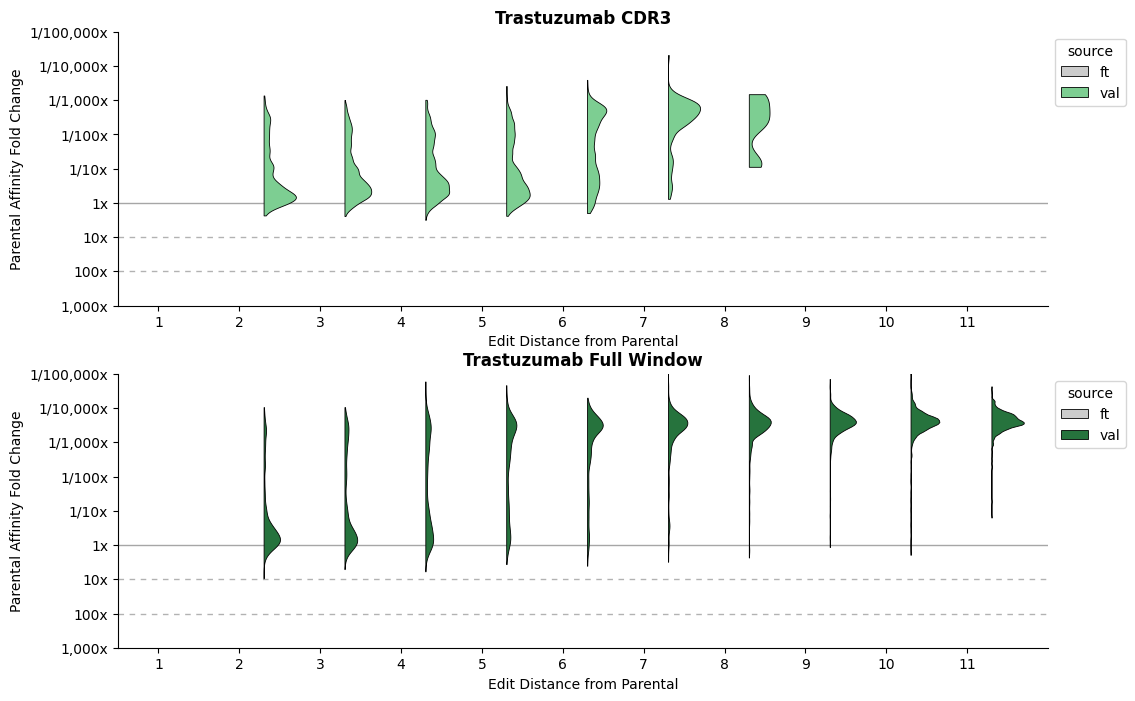

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8), gridspec_kw={"hspace": 0.25})

plot_violins_val(
    df_trast_cdr, ax=axs[0], title="Trastuzumab CDR3", color=TRASTCDR_COLOR
)
plot_violins_val(
    df_trast_full, ax=axs[1], title="Trastuzumab Full Window", color=TRASTFULL_COLOR
)

fig.savefig(
    PLOT_DIR / "alphabind_violins_by_distance_trastuzumab",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

### Sequence diversity analysis

---

Compute and plot entropy in bits of ab sequence at each non-indel position for AlphaBind candidates. Uses ANARCI with the Chothia scheme to number candidates and parental sequences.

In [14]:
# read in anarci heavy chain outputs for alphabind candidates
df_vhh72_anarci = pd.read_csv(ANARCI_DIR / "vhh72_anarci_H.csv")
df_pembro_anarci = pd.read_csv(ANARCI_DIR / "pembrolizumab-scfv_anarci_H.csv")
df_pp489_anarci = pd.read_csv(ANARCI_DIR / "aab-pp489_anarci_H.csv")

df_trast_cdr_anarci = pd.read_csv(ANARCI_DIR / "trastuzumab-scfv-cdr_anarci_H.csv")
df_trast_full_anarci = pd.read_csv(ANARCI_DIR / "trastuzumab-scfv-full_anarci_H.csv")

In [15]:
def seq_entropy(df_seqs):
    """
    Calculates position-wise Shannon entropy (in bits) for a set of sequences.

    Parameters
    ----------
    df_seqs : pandas.DataFrame
        DataFrame where each row is a sequence and each column is a position.
        Positions should be numerically labeled starting from '1'.

    Returns
    -------
    pandas.DataFrame
        DataFrame containing entropy values for each position, with columns:
        - 'index': position labels
        - 0: entropy values in bits
    """
    col_entropy = lambda col: entropy(col.value_counts(), base=2)  # noqa: E731
    df_entropy = pd.DataFrame(df_seqs.apply(col_entropy, axis=0)).reset_index()
    return df_entropy


def custom_ticks(df):
    """
    Generates evenly spaced tick positions and labels for sequence positions.

    Creates ticks at multiples of 10. For positions that don't exist in the
    data (e.g., due to gaps), interpolates tick positions between existing ones.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with position-labeled columns (e.g., '1', '2', etc.)

    Returns
    -------
    tuple
        Two lists:
        - tick_positions: float, positions for tick marks
        - tick_labels: str, labels for the ticks
    """

    def extract_number(col):
        match = re.match(r"(\d+)", col)
        return int(match.group(1)) if match else None

    columns = df.columns.tolist()
    tick_positions = []
    tick_labels = []
    max_num = max(
        extract_number(col) for col in columns if extract_number(col) is not None
    )

    for num in range(10, max_num + 1, 10):
        matching_cols = [
            i for i, col in enumerate(columns) if extract_number(col) == num
        ]

        if matching_cols:
            # if match, use the first occurrence
            pos = matching_cols[0]
            tick_positions.append(pos)
            tick_labels.append(columns[pos])
        else:
            # if no match, find the closest existing columns before and after
            before = max(
                (
                    i
                    for i, col in enumerate(columns)
                    if extract_number(col) and extract_number(col) < num
                ),
                default=None,
            )
            after = min(
                (
                    i
                    for i, col in enumerate(columns)
                    if extract_number(col) and extract_number(col) > num
                ),
                default=None,
            )

            if before is not None and after is not None:
                # place tick between existing columns
                pos = (before + after) / 2
                tick_positions.append(pos)
                tick_labels.append(str(num))
            elif before is not None:
                # place tick after the last existing column
                pos = before + 0.5
                tick_positions.append(pos)
                tick_labels.append(str(num))
            elif after is not None:
                # place tick before the first existing column
                pos = after - 0.5
                tick_positions.append(pos)
                tick_labels.append(str(num))

    return tick_positions, tick_labels


def plot_seq_entropy(df_seqs, title="", color="k", ylim=2.5):
    """
    Creates a bar plot of sequence entropy by position with parental sequence overlay.

    Generates a bar plot showing Shannon entropy at each position in the sequence
    alignment, with the parental sequence shown on a secondary x-axis. Gaps in the
    parental sequence are excluded from the plot, and insertions are ignored for
    visualization purposes.

    Parameters
    ----------
    df_seqs : pandas.DataFrame
        DataFrame where each row is a sequence and each column is a position.
        The last row should contain the parental sequence.
    title : str, optional
        Title for the plot
    color : str, optional
        Color for the entropy bars (default: 'k')
    ylim : float, optional
        Upper limit for y-axis (default: 2.5)

    Returns
    -------
    matplotlib.figure.Figure
        The generated figure object
    """
    df_seqs = df_seqs.set_index("Id").loc[:, "1":]
    # grab the parental sequence, last in the table
    parental_seq = df_seqs.iloc[-1]
    df_seqs = df_seqs.loc[:, parental_seq != "-"]
    df_entropy = seq_entropy(df_seqs)

    fig, ax = plt.subplots(1, figsize=(12, 2))
    sns.barplot(data=df_entropy, x="index", y=0, color=color)

    parental_seq_ungapped = "".join(parental_seq[parental_seq != "-"])

    ax.set_ylabel("Entropy (bits)")
    ax.set_ylim(0, ylim)
    ticks, labels = custom_ticks(df_seqs)
    ax.set_xticks(ticks, labels)

    sec = ax.secondary_xaxis(0)
    sec.set_xticks(range(len(parental_seq_ungapped)), parental_seq_ungapped, fontsize=7)
    sec.tick_params(axis="x", length=0, pad=20)
    ax.set_xlabel("Position", labelpad=25)
    ax.set_title(title, fontweight="bold")
    sns.despine()
    return fig

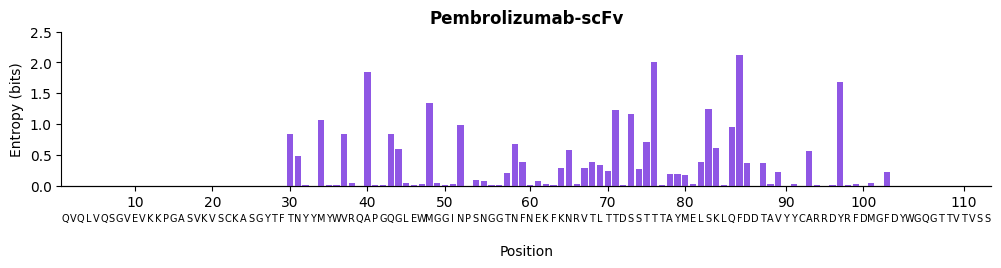

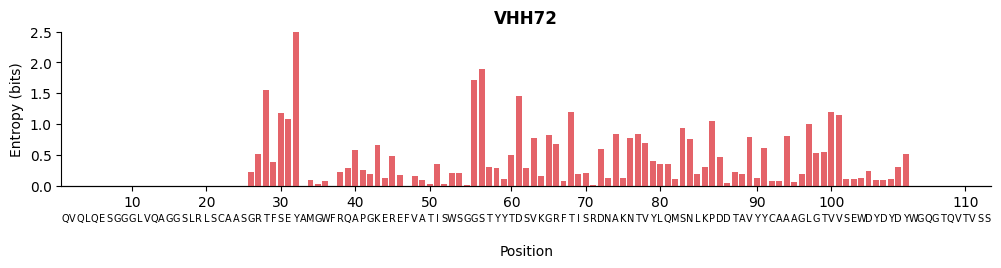

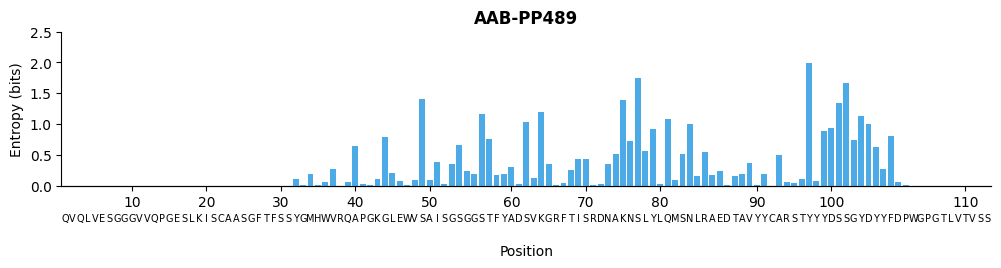

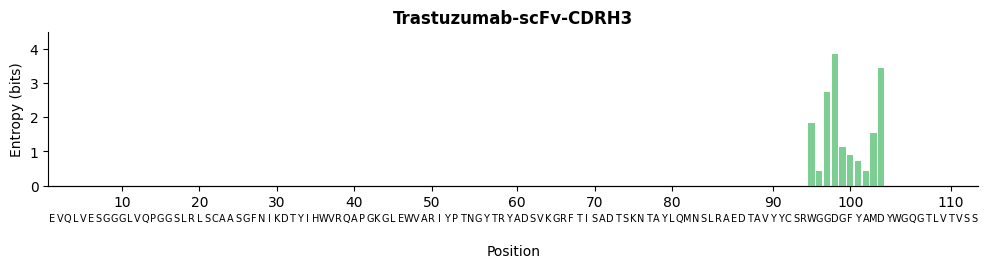

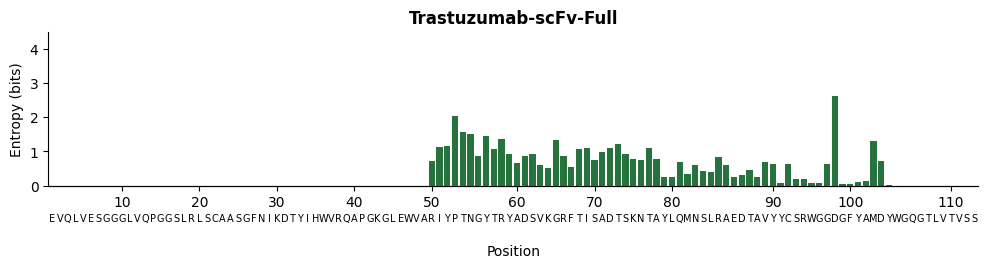

In [16]:
fig = plot_seq_entropy(df_pembro_anarci, title="Pembrolizumab-scFv", color=PEMBRO_COLOR)
fig.savefig(
    PLOT_DIR / "seq_entropy_pembrolizumab-scfv",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

fig = plot_seq_entropy(df_vhh72_anarci, title="VHH72", color=VHH72_COLOR)
fig.savefig(
    PLOT_DIR / "seq_entropy_vhh72", dpi=300, facecolor="white", bbox_inches="tight"
)

fig = plot_seq_entropy(df_pp489_anarci, title="AAB-PP489", color=PP489_COLOR)
fig.savefig(
    PLOT_DIR / "seq_entropy_aab-pp489", dpi=300, facecolor="white", bbox_inches="tight"
)

fig = plot_seq_entropy(
    df_trast_cdr_anarci, title="Trastuzumab-scFv-CDRH3", color=TRASTCDR_COLOR, ylim=4.5
)
fig.savefig(
    PLOT_DIR / "seq_entropy_trastuzumab-scfv-cdr",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

fig = plot_seq_entropy(
    df_trast_full_anarci, title="Trastuzumab-scFv-Full", color=TRASTFULL_COLOR, ylim=4.5
)
fig.savefig(
    PLOT_DIR / "seq_entropy_trastuzumab-scfv-full",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

### BLI analysis

---

Plot results for BLI measurements of parental and AlphaBind's top 5 predicted candidates.

In [17]:
# read in BLI results
df_pp489_bli = pd.read_csv(BLI_DIR / "aab-pp489_bli_results.csv")
df_vhh72_bli = pd.read_csv(BLI_DIR / "vhh72_bli_results.csv")
df_pembro_bli = pd.read_csv(BLI_DIR / "pembrolizumab-scfv_bli_results.csv")
df_trast_bli = pd.read_csv(BLI_DIR / "trastuzumab-scfv_bli_results.csv")

In [18]:
def plot_bli_results(df_bli, ax=None, color="k", title=""):
    """
    Creates a point plot comparing BLI affinity measurements between parental and AlphaBind sequences.

    Plots BLI KD measurements on a log scale in nM, with parental sequences and AlphaBind-designed
    sequences separated on the x-axis. Each point represents a measurement, with edit distances from
    parental sequence shown in parentheses. A horizontal line shows the geometric mean of parental measurements.
    N.B. denotes a non-binder.

    Parameters
    ----------
    df_bli : pandas.DataFrame
        DataFrame containing BLI results with columns:
        - 'Clone ID': str, sequence identifier containing type (alphabind/parental) and distance info
        - 'KD(M)': float or 'N.B.', measured dissociation constant in molar
    ax : matplotlib.axes.Axes, optional
        Axes on which to draw the plot. Creates new figure if None.
    color : str, optional
        Color for AlphaBind points (default: 'k')
    title : str, optional
        Title for the plot
    """
    df_bli["selection"] = df_bli["Clone ID"].str.extract(r"(alphabind|parental)")
    df_bli["edit_distance"] = (
        df_bli["Clone ID"].str.extract(r".+_d(\d+)").fillna(0).astype(int)
    )
    df_bli["KD(M)"] = df_bli["KD(M)"].replace({"N.B.": np.nan}).astype(float)
    # filter out negative controls
    df_bli = df_bli[~df_bli["selection"].isnull()]
    # convert KD(M) to KD(nM)
    df_bli["KD(nM)"] = df_bli["KD(M)"] * 1e9
    # cmopute geometric mean for parental
    df_bli_parental = df_bli[df_bli["selection"] == "parental"]
    parental_mean_aff = None
    if df_bli_parental.shape[0]:
        parental_mean_aff = df_bli_parental["KD(nM)"].prod() ** (
            1 / df_bli_parental.shape[0]
        )

    df_bli["x_pos"] = df_bli["selection"].replace({"parental": 0, "alphabind": 1})
    np.random.seed(2)
    df_bli["x_pos"] = df_bli["x_pos"].apply(lambda x: x + np.random.normal(0, 0.05))

    palette = {"parental": "#ccc", "alphabind": color}

    sns.scatterplot(
        ax=ax,
        s=50,
        edgecolor="black",
        linewidth=1,
        data=df_bli,
        palette=palette,
        y="KD(nM)",
        x="x_pos",
        hue="selection",
        alpha=0.85,
        legend=False,
    )
    if parental_mean_aff:
        ax.axhline(parental_mean_aff, color="k", dashes=[4], linewidth=1, zorder=-1)

    ax.set_ylabel("Affinity (KD nM) by BLI")
    ax.set_yscale("log")
    ax.set_ylim(0.1, 100)
    ax.set_yticks([0.1, 1, 10, 100], labels=["1/10", "1", "10", "100"])

    ax.set_xlabel("")
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1], labels=["Parental", "Top 5 AlphaBind"])
    ax.set_title(title, fontweight="bold")
    sns.despine()

    # Add labels to each point
    for _, row in df_bli.iterrows():
        if row["edit_distance"] > 0:
            ax.text(
                row["x_pos"],
                row["KD(nM)"],
                str("   (" + str(row["edit_distance"]) + ")"),
                color="black",
                fontsize=10,
                ha="left",
                va="top",
            )

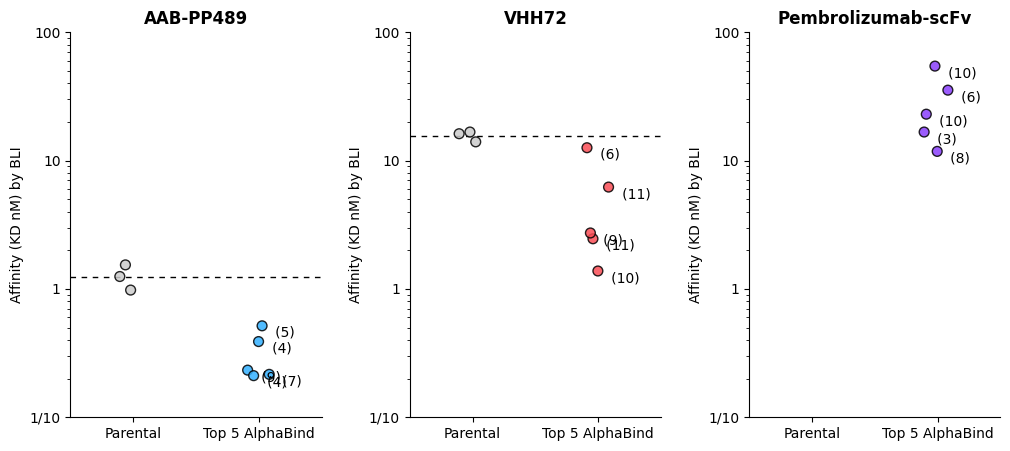

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), gridspec_kw={"wspace": 0.35})

plot_bli_results(df_pp489_bli, axs[0], color=PP489_COLOR, title="AAB-PP489")
plot_bli_results(df_vhh72_bli, axs[1], color=VHH72_COLOR, title="VHH72")
plot_bli_results(df_pembro_bli, axs[2], color=PEMBRO_COLOR, title="Pembrolizumab-scFv")

fig.savefig(
    PLOT_DIR / "alphabind_bli_results", dpi=300, facecolor="white", bbox_inches="tight"
)

In [20]:
def plot_bli_trastuzumab(df_bli, ax=None):
    """
    Similar to the function shown above (plot_bli_results), but with modifications to apply
    to the Trastuzumab experiment.

    Parameters
    ----------
    df_bli : pandas.DataFrame
        DataFrame containing BLI results with columns:
        - 'Clone ID': str, sequence identifier containing type (cdr_alphabind/full_alphabind/dms/parental) and distance info
        - 'KD(M)': float or 'N.B.', measured dissociation constant in molar
    ax : matplotlib.axes.Axes, optional
        Axes on which to draw the plot. Creates new figure if None.
    """

    df_bli["selection"] = df_bli["Clone ID"].str.extract(
        r"(cdr_alphabind|full_alphabind|parental|dms)"
    )
    df_bli["edit_distance"] = (
        df_bli["Clone ID"].str.extract(r".+_d(\d+)").fillna(0).astype(int)
    )
    df_bli["KD(M)"] = df_bli["KD(M)"].replace({"N.B.": np.nan}).astype(float)
    # filter out negative controls
    df_bli = df_bli[~df_bli["selection"].isnull()]
    # convert KD(M) to KD(nM)
    df_bli["KD(nM)"] = df_bli["KD(M)"] * 1e9
    # cmopute geometric mean for parental
    df_bli_parental = df_bli[df_bli["selection"] == "parental"]
    parental_mean_aff = None
    if df_bli_parental.shape[0]:
        parental_mean_aff = df_bli_parental["KD(nM)"].prod() ** (
            1 / df_bli_parental.shape[0]
        )

    df_bli["x_pos"] = df_bli["selection"].replace(
        {"parental": 0, "dms": 1, "cdr_alphabind": 2, "full_alphabind": 3}
    )
    np.random.seed(1)
    df_bli["x_pos"] = df_bli["x_pos"].apply(lambda x: x + np.random.normal(0, 0.1))

    if not ax:
        fig, ax = plt.subplots(1, figsize=(6, 10))
    sns.scatterplot(
        ax=ax,
        s=50,
        edgecolor="black",
        linewidth=1,
        data=df_bli,
        y="KD(nM)",
        x="x_pos",
        hue="selection",
        hue_order=["parental", "dms", "cdr_alphabind", "full_alphabind"],
        alpha=0.85,
        legend=False,
        palette=["#ccc", "#555", TRASTCDR_COLOR, TRASTFULL_COLOR],
    )

    ax.axhline(parental_mean_aff, color="k", dashes=[4], linewidth=1, zorder=-1)

    ax.set_ylabel("BLI Affinity (KD nM)")
    ax.set_yscale("log")
    ax.set_ylim(0.1, 11)
    ax.set_yticks([0.1, 1, 10], labels=["1/10", "1", "10"])

    ax.set_xlabel("")
    ax.set_xlim(-0.5, 3.5)
    ax.set_xticks(
        [0, 1, 2, 3], labels=["Parental", "DMS", "AlphaBind CDR", "AlphaBind Full"]
    )

    sns.despine()

    # Add labels to each point
    for _, row in df_bli.iterrows():
        if row["edit_distance"] > 0:
            ax.text(
                row["x_pos"],
                row["KD(nM)"],
                str("   (" + str(row["edit_distance"]) + ")"),
                color="black",
                fontsize=10,
                ha="left",
                va="top",
            )

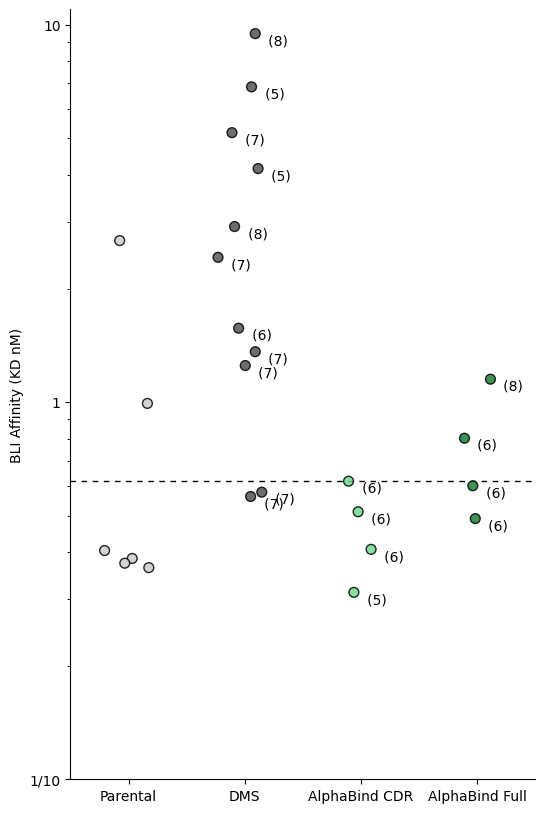

In [21]:
fig, ax = plt.subplots(1, figsize=(6, 10))
plot_bli_trastuzumab(df_trast_bli, ax=ax)
fig.savefig(
    PLOT_DIR / "alphabind_bli_results_trastuzumab",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)

### TIGIT Binder Humanization Analysis

---

Plot sequences proposed to humanize an optimized PP489 and their resulting BLI affinities.

In [22]:
# read in BLI data for humanized variants of PP3115
df_pp3115 = pl.read_csv(BLI_DIR / "aab-pp3115_germlined_descendants_ps_metrics.csv")

In [23]:
def plot_humanized_muts_bli(df, axs=None):
    """Generate a composite heatmap visualizing antibody mutations and binding measurements.

    Creates a figure with two panels:
    1. Left panel: Heatmap showing mutations relative to parental sequence, with color-coding
       for non-germline and liability positions
    2. Right panel: Heatmap showing predicted and experimentally measured binding affinities

    Parameters
    ----------
    df : polars.DataFrame
        Input dataframe containing:
        - 'description': str, mutation description (e.g., 'S33A_T57Y')
        - 'predicted_affinity': float, log10(KD) predictions
        - 'bli_human_tigit': float, BLI-measured KD in M
        - 'pp_lot': str, sample identifier with 'PP3115' representing parental"""

    # transform predicted affinities and BLI affinities into KD nM
    df = df.with_columns(
        pl.lit(10).pow(pl.col("predicted_affinity")).alias("predicted_affinity"),
        pl.col("bli_human_tigit") * 1e9,
    )
    # extract positions mutated from the descriptions
    all_muts = (
        df.filter(pl.col("description") != "parental")["description"]
        .str.extract_all(r"([A-Z]\d+[A-Z]{0,1}[A-Z])")
        .explode()
        .to_list()
    )
    all_posx = sorted(
        list(set([m[:-1] for m in all_muts])),
        key=lambda pos: (
            int("".join(filter(str.isdigit, pos))),
            "".join(filter(str.isalpha, pos)),
        ),
    )

    # helper function to take in a list of mutations in a polars df and return a dict of mutations at each relevant position
    def annotate_mut(row):
        annots = dict.fromkeys(all_posx, "")
        muts = row["muts"]
        for mut in muts:
            pos = mut[:-1]
            annots[pos] = mut[-1]
        return annots

    # extract mutations from descriptions, explode to give each possible position it's own column
    df = (
        df.with_columns(
            pl.col("description")
            .str.extract_all(r"([A-Z]\d+[A-Z]?[A-Z])")
            .alias("muts")
        )
        .with_columns(pl.struct(pl.all()).map_elements(annotate_mut).alias("annots"))
        .unnest("annots")
        .to_pandas()
    )

    df_annotated_muts = df.loc[:, all_posx[0] :]
    # manually annotating non-germline (1) / liability motif (2-3) positions
    df_mut_heatmap = df_annotated_muts.mask(
        lambda x: x != "",
        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3]] * df_annotated_muts.shape[0],
    ).replace({"": 0})
    df_mut_heatmap.loc[0] = [0] * df_mut_heatmap.shape[1]
    df_mut_heatmap = df_mut_heatmap.set_index(df["pp_lot"])

    df_annotated_muts.loc[0] = [c[0] for c in df_annotated_muts.columns]
    df_annotated_muts = df_annotated_muts.mask(
        lambda x: x == "",
        [df_annotated_muts.loc[0].to_list()] * df_annotated_muts.shape[0],
    )

    if axs is None:
        fig, axs = plt.subplots(
            ncols=2,
            figsize=(10, 5),
            gridspec_kw={"wspace": 0, "width_ratios": [2.5, 1]},
        )
    sns.heatmap(
        df_mut_heatmap,
        annot=df_annotated_muts,
        fmt="",
        annot_kws={"color": "k"},
        cmap=["#fff", "#AC94D1", "#D19497", "#94BAD1"],
        linewidths=0.5,
        linecolor="k",
        ax=axs[0],
        cbar=False,
    )

    sns.heatmap(
        df[["predicted_affinity", "bli_human_tigit"]],
        norm=LogNorm(vmin=0.5, vmax=1e3),
        cmap="gray",
        annot=df[["predicted_affinity", "bli_human_tigit"]].applymap(format_2_sig_figs),
        linewidths=0.5,
        linecolor="k",
        fmt="",
    )

    axs[0].spines[:].set_visible(True)
    axs[1].spines[:].set_visible(True)

    axs[0].set_ylabel("")
    axs[0].set_xlabel("Position")
    axs[0].set_xticklabels([c[1:] for c in df_mut_heatmap.columns], fontsize=10)
    axs[0].tick_params(labeltop=True, bottom=False, labelbottom=False, rotation=0)

    axs[1].set_yticks([])
    axs[1].set_xticklabels(["Predicted Affinity (nM)", "BLI Affinity (nM)"])
    axs[1].collections[0].colorbar.ax.spines[:].set_visible(True)


def format_2_sig_figs(x):
    """
    Format number to n significant figures, preserving trailing zeros
    Returns string representation
    """
    if pd.isna(x):
        return ""
    if x == 0:
        return "0.00"
    if x >= 100:  # Use scientific notation for larger numbers
        return f"{x:.1e}".replace("e+0", "e")
    else:
        # Calculate number of decimal places needed for n significant figures
        decimals = 1 - int(np.floor(np.log10(abs(x))))
        return f"{x:.{max(0, decimals)}f}"

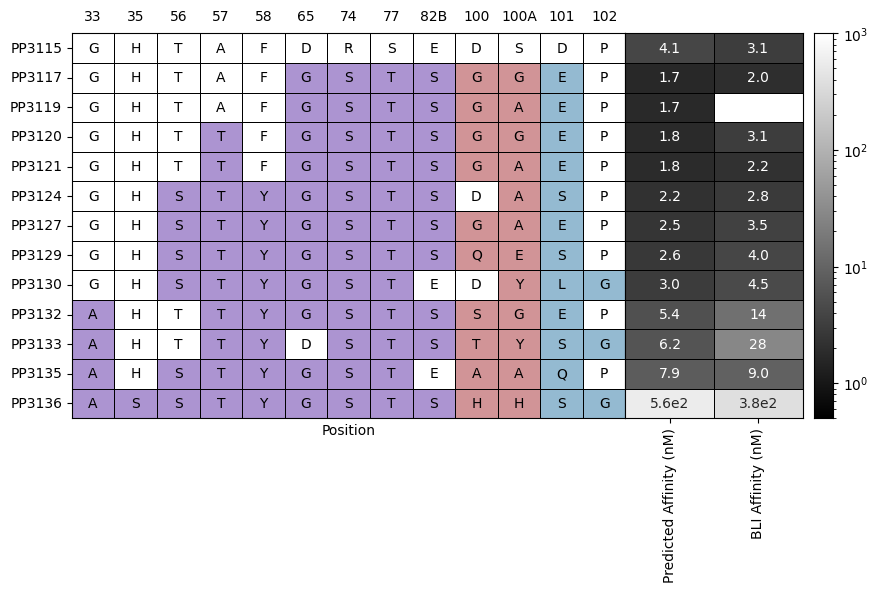

In [24]:
fig, axs = plt.subplots(
    ncols=2, figsize=(10, 5), gridspec_kw={"wspace": 0, "width_ratios": [2.5, 1]}
)
plot_humanized_muts_bli(df_pp3115, axs=axs)
fig.savefig(
    PLOT_DIR / "humanized_pp3115_mut_bli_heatmap",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
)